In [3]:
from PIL import Image
import torch
from torch import Tensor, linalg
import numpy as np

Read data

In [200]:
image_count_per_person = 10
person_count = 1
images = [Image.open(f"../data/s{j + 1}/{i + 1}.pgm") for i in range(image_count_per_person) for j in range(person_count)]

data = np.array(images)
data.resize((image_count_per_person * person_count, images[0].width * images[0].height))
data = Tensor(data)

Original PCA algorithm\
Running Time: $O(d^3)$ to calculate the eigen values and eigen vectors of $ \Sigma_{d \times d}$ matrix\
\
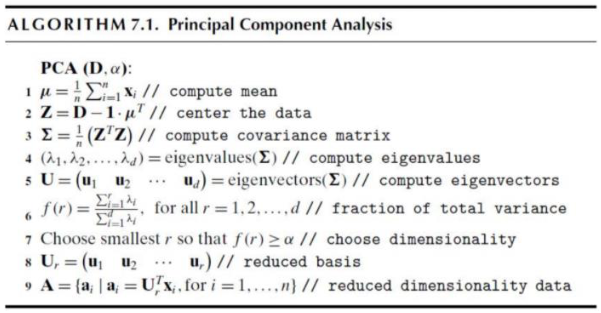

In [56]:
def pca1(data: Tensor, alpha: float) -> Tensor:
    centered_data: Tensor = data - data.mean(0)
    covariance: Tensor = 1 / len(data) * centered_data.T @ centered_data

    eigen_values, eigen_vectors = linalg.eigh(covariance)

    variance: float = covariance.trace().numpy()
    projected_variance = 0.0

    i = len(eigen_values) - 1
    while i >= 0 and projected_variance < alpha * variance:
        projected_variance += eigen_values[i]
        i -= 1

    eigen_vectors = torch.fliplr(eigen_vectors[:, i + 1:])

    return data @ eigen_vectors

In [192]:
pca1(data, 0.8)

tensor([[-9.3552e+03, -7.9087e+03, -2.4372e+03,  ..., -2.9994e+02,
          1.6506e+02, -5.6371e+02],
        [-8.6998e+03, -6.1307e+03, -1.9186e+03,  ..., -5.3984e+00,
          1.7888e+02, -4.3669e+02],
        [-7.9627e+03, -7.2608e+03, -8.3477e+01,  ...,  2.8649e+02,
          1.7648e+02, -3.6640e+02],
        ...,
        [-6.0040e+03, -7.8446e+03, -9.6201e+01,  ...,  2.3931e+02,
          1.6761e+02, -7.4175e+02],
        [-5.1594e+03, -4.7759e+03,  6.7011e+01,  ...,  6.4504e+02,
          4.3894e+02, -5.7031e+02],
        [-8.3588e+03, -7.3135e+03,  1.4888e+03,  ...,  2.6679e+01,
          2.1479e+02, -3.1819e+02]])

Enhanced PCA algorithm\
Running Time: $O(n^3)$ to calculate the eigen values and eigen vectors of $ \frac{1}n \mathbf{X}_{n \times d}\mathbf{X}_{d \times n}^T  $ matrix\
Reference: Section 12.1.4 from C. M. Bishop, Pattern Recognition and Machine Learning

In [201]:
def pca2(data: Tensor, alpha: float) -> Tensor:
    centered_data = data - data.mean(0)

    eigen_values, eigen_vectors = torch.linalg.eig(1 / len(data) * centered_data @ centered_data.T)
    eigen_values = eigen_values.real
    eigen_vectors = eigen_vectors.real

    variance: float = (1 / len(data) * centered_data.T @ centered_data).trace().numpy()
    projected_variance = 0.0

    idxs = torch.argsort(eigen_values, descending=True)
    eigen_values = eigen_values[idxs]
    eigen_vectors = eigen_vectors[:, idxs]

    i = 0
    while i < len(eigen_values) and projected_variance < alpha * variance:
        projected_variance += eigen_values[i]
        i += 1

    new_basis = centered_data.T @ eigen_vectors
    new_basis /= torch.sqrt(eigen_values * len(data))

    new_basis = new_basis[:, :i]
    print(new_basis.shape)

    return new_basis

In [202]:
new_basis = pca2(data, 0.8)
projected_data = data @ new_basis
new_basis, projected_data

i = 5
torch.Size([10304, 5])


(tensor([[-6.7276e-04, -1.9550e-04,  4.6486e-03, -8.2595e-05,  1.3163e-03],
         [ 5.8762e-04,  4.8408e-04,  5.1460e-03,  7.9514e-04,  1.9834e-03],
         [ 2.3024e-03,  3.6975e-03,  5.3106e-03,  2.7793e-03,  5.0195e-03],
         ...,
         [ 2.9894e-03, -1.6071e-02,  4.9626e-03, -4.7139e-03, -1.2428e-02],
         [ 4.3927e-03, -1.1833e-02,  4.0387e-03, -1.1045e-03, -1.3913e-02],
         [ 5.0924e-03, -1.5915e-02,  6.1383e-03, -2.5600e-03, -1.3155e-02]]),
 tensor([[ 1271.2837,  -414.7813,  2545.9031,   274.2806,  -333.1669],
         [ 1362.5728,  1221.0071,  7168.0015,   457.2370,   717.0794],
         [ 1691.8022,  -164.8530,  3418.9702, -1065.1201,  2755.5054],
         [-1961.4717, -2692.2300,  5332.8145, -1152.4095,  1027.3682],
         [-1442.2825,   886.7914,  6097.3564,  -324.0635,  1220.3024],
         [  479.7938, -3214.9863,  5644.5518,  -603.1715,   183.5756],
         [  402.8020, -1302.4917,  4127.0034,  1626.2461,   648.8504],
         [-1921.9216,    -9.307